In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import matplotlib.mlab as mlab
from math import sqrt
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_all_alphas, weather_all_costs, prediction_humidity, model_02, validate, dengue_weather

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def seperate_train_test(all_data, train_data, peak):
    peak_for_txt = peak -10
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,peak_for_txt,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,peak_for_txt,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

def plot_all_predictions(LAG, real, train, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real.cases,label='real')
    graph_title = "%s's Dengue Prediction with Weather Data"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    real_max = real.cases.max()
    train_max = train.cases.max()
    peak = max(real_max,train_max)
    seperate_train_test(real,train,peak)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,peak/2,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend(loc='best')
#     img_name = "prediction-for-%s.pdf"%(province)
#     plt.savefig(img_name)
    
def show_predictions(params, real, train, province, ws):
    LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, AVGRH_WEEKS = params[0], params[1], params[2], params[3]
    
    predictions_to_plot = prediction_humidity.get_predictions(
        LAG, 
        TEMPERATURE_WEEKS,
        RAIN_WEEKS,
        AVGRH_WEEKS,
        real,
        ws,
        province)
    
    plot_all_predictions(LAG, 
                         real,
                         train,
                         province,
                         [1,2,4,8,16],
                         predictions_to_plot)


In [9]:
all_weather = pd.read_csv("weather01-16.csv")
all_weather.stn_name = all_weather.stn_name.apply(dengue_weather.remove_space)
all_dengue = pd.read_csv("all-dengues.csv")
all_dengue = all_dengue.rename(columns = {'จังหวัด' : 'province'})

In [10]:
                       # province_dengue: province_weather
provinces_to_predict = {#"Bangkok":"BangkokMetropolis",
                        "PrachuapKhiriKhan":"PrachuapKhiriKhan",
                        "PhraNakhonSiAyutthaya":"AyuttayaAgromet", 
                        "Songkhla":"PhatthalungAgromet", 
                        "Ratchaburi":"Ratchaburi", 
                        "ChonBuri":"ChonBuri", 
                        "NongKhai":"NongKhai",
                        "SakonNakhon":"SakonNakhonAgromet",
                        "ChiangMai":"ChiangMai",
                        "ChiangRai":"ChiangRai",
                        #"Pathumthani":"PathumthaniAgromet",
                        "SamutPrakan":"PilotStation",
                        "NakhonPathom":"KamphaengSaenAgromet", 
                        "MahaSarakham":"KosumPhisai",  
                        "Pattani":"PattaniAirport", 
                        "SuratThani":"SuratThaniAgromet"}

province_data = {}
for province_for_dengue in provinces_to_predict:
    province_for_weather = provinces_to_predict.get(province_for_dengue)
    print province_for_dengue, province_for_weather
    
    province_data_to_predict = dengue_weather.get_dengue_weather_by_province(
                                                                    province_for_dengue, 
                                                                    province_for_weather, 
                                                                    all_dengue, 
                                                                    all_weather)
    province_data[province_for_dengue] = province_data_to_predict
    
# province data is dictionary of province to its train and real data, idx 0 and 1
# ex --> province_data.get('Bangkok')[0]

PhraNakhonSiAyutthaya AyuttayaAgromet
SamutPrakan PilotStation
SuratThani SuratThaniAgromet
ChiangRai ChiangRai
ChiangMai ChiangMai
ChonBuri ChonBuri
Pattani PattaniAirport
Songkhla PhatthalungAgromet
Ratchaburi Ratchaburi
NongKhai NongKhai
SakonNakhon SakonNakhonAgromet
PrachuapKhiriKhan PrachuapKhiriKhan
MahaSarakham KosumPhisai
NakhonPathom KamphaengSaenAgromet


### perform error testing on test data

In [11]:
def get_distances(LAG, all_predictions, real):

    def distance(prediction, real):
        all_residual = real - prediction
        return all_residual

    weeks = [1,2,4,8,16]
    ret = []
    for idx,prediction in enumerate(all_predictions):
        cur_pred = np.array(prediction)
        # compare with real
        # doesnt take into the accout of the predicted week(s)
        cur_pred_range = cur_pred[:-weeks[idx]]
        real_range = real.cases[LAG+weeks[idx]:]
        ret.append(distance(cur_pred_range,real_range))

    return ret

def get_distances_percent(all_predicitions, real):
    np_all_pred = np.array(all_predicitions)
    np_real = np.array(real)
    ret = []
    for idx,real_case in enumerate(np_real):
        if real_case >= 100:
            pred_case = np_all_pred[idx]
#             print pred_case, real_case
            score = real_case - pred_case
            percent_ = score/real_case
            ret.append(percent_)
    return np.array(ret)

In [12]:
%%time
chosen_ws = glob.glob("province-ws-*.csv")
test_err = []
for ws_set_file in chosen_ws:
    raw_cur_ws = pd.read_csv(ws_set_file).T
    cur_ws = np.array(raw_cur_ws)[0]
    cur_province = ws_set_file[16:-4]
    cur_train = province_data[cur_province][0]
    cur_real = province_data[cur_province][1]
    cur_test = province_data[cur_province][2]
#     print "cur_province", cur_province
#     print "cur_test", len(cur_test)
    if cur_province == "ChiangMai":
    
        predictions_to_validate = prediction_humidity.get_predictions(
            19,9,15,1,
            cur_test,
            cur_ws)

        cur_test_err = get_distances(
            19,
            predictions_to_validate,
            cur_test)

        test_err.append(cur_test_err)
    
#     show_predictions(
#                     [19,9,15,1],
#                     cur_real,
#                     cur_train,
#                     cur_province,
#                     cur_ws)

CPU times: user 1.26 s, sys: 27.4 ms, total: 1.29 s
Wall time: 1.35 s


CPU times: user 7.26 s, sys: 177 ms, total: 7.44 s
Wall time: 8.84 s


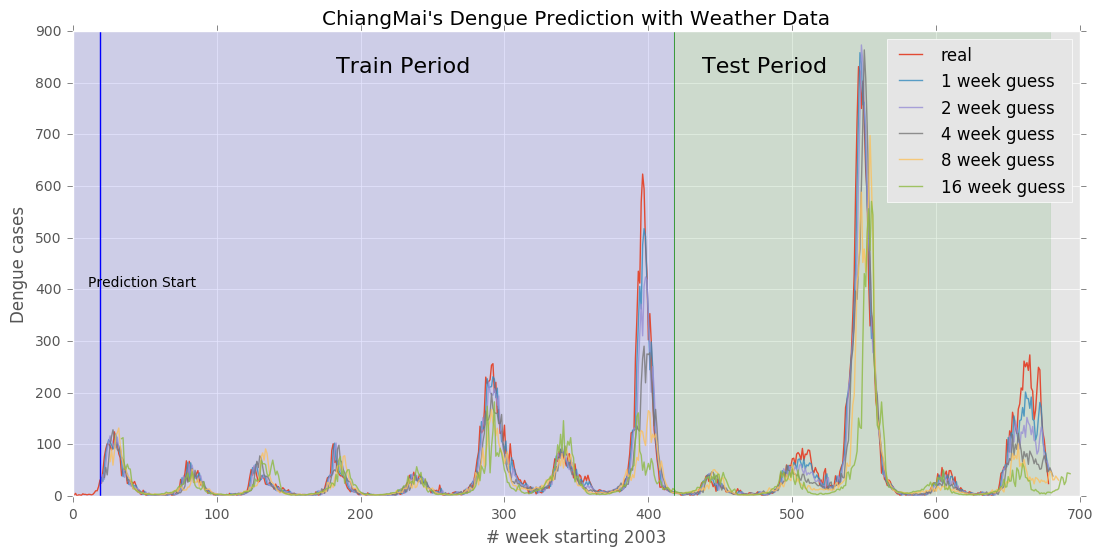

In [13]:
%%time
chosen_ws = glob.glob("province-ws-for-ChiangMai.csv")
test_err = []
for ws_set_file in chosen_ws:
    raw_cur_ws = pd.read_csv(ws_set_file).T
    cur_ws = np.array(raw_cur_ws)[0]
    cur_province = ws_set_file[16:-4]
    cur_train = province_data[cur_province][0]
    cur_real = province_data[cur_province][1]
    cur_test = province_data[cur_province][2]
#     print "cur_province", cur_province
#     print "cur_test", len(cur_test)
    
    predictions_to_validate = prediction_humidity.get_predictions(
        19,9,15,1,
        cur_test,
        cur_ws)
    
    train_to_validate = prediction_humidity.get_predictions(
        19,9,15,1,
        cur_train,
        cur_ws)

    cur_test_err = get_distances(
        19,
        predictions_to_validate,
        cur_test)

    test_err.append(cur_test_err)
    
    show_predictions(
                    [19,9,15,1],
                    cur_real,
                    cur_train,
                    cur_province,
                    cur_ws)

## STOP

In [239]:
predictions_to_validate = prediction_humidity.get_predictions(
        19,9,15,1,
        cur_real,
        cur_ws)

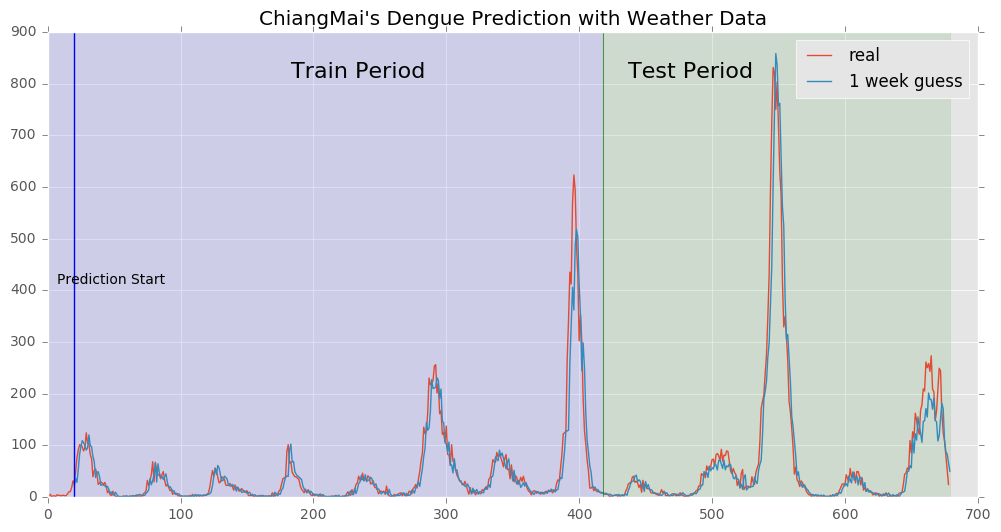

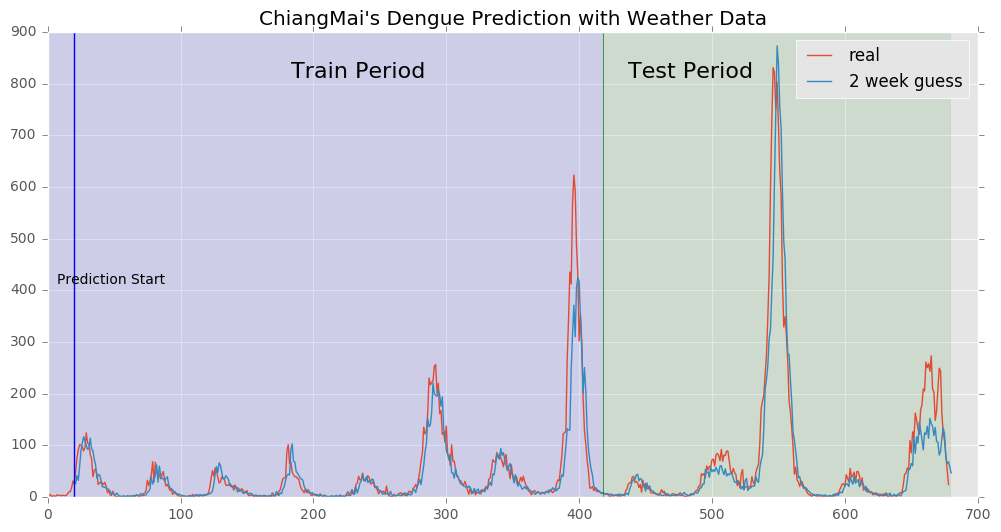

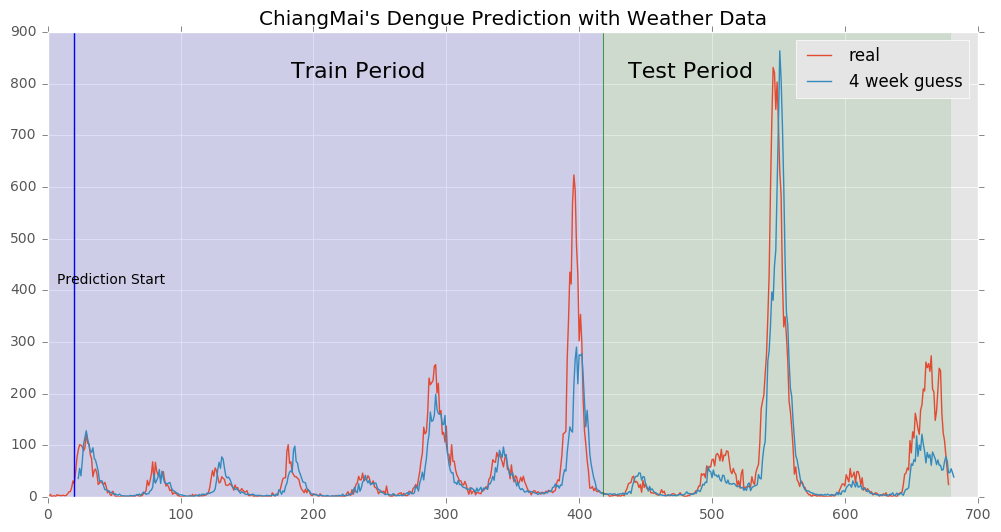

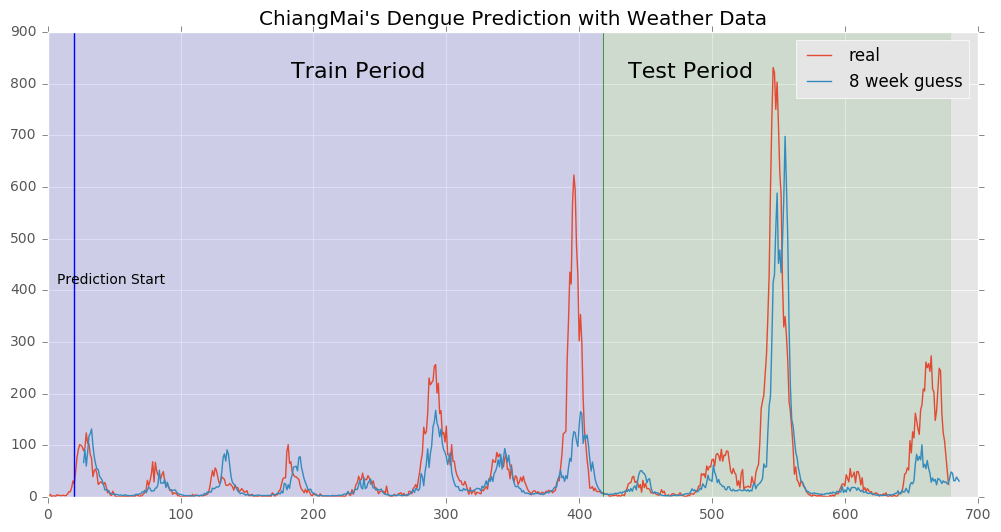

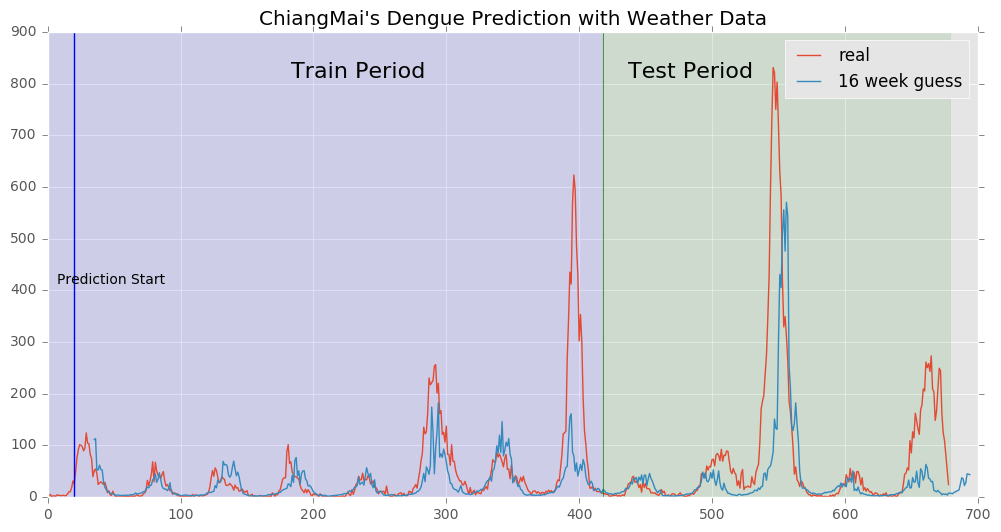

In [310]:
def simple_seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,810,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,810,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)
    plt.xlim(0,700)

train_data = np.array(cur_train)
all_data = np.array(cur_real.cases)
wks = [1,2,4,8,16]
for i in range(5):
    wk = wks[i]
    pred_data = predictions_to_validate[i]
    plt.figure(figsize=(12,6))
    range_ = xrange(20+(wk-1),len(pred_data)+20+(wk-1))
    plt.plot(all_data,label='real')
    guess_label = '%d week guess'%(wk)
    plt.plot(range_,pred_data,label=guess_label)
    plt.axvline(20)
    plt.text((19*2)+10,420,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.title("ChiangMai's Dengue Prediction with Weather Data")
    plt.legend()
    simple_seperate_train_test(all_data,train_data)
    title = "product-of-autoregression-with-seasonal-and-weather-%d.pdf"%(wk)
    plt.savefig(title,dpi = 300, bbox_inches='tight')
    plt.figure()
#     break

# plt.figure(figsize=(12,6))
# range_ = xrange(19+15,len(pred_data)+19+15)
# plt.plot(range_,predictions_to_validate[4])
# plt.plot(all_data)

IndexError: list index out of range

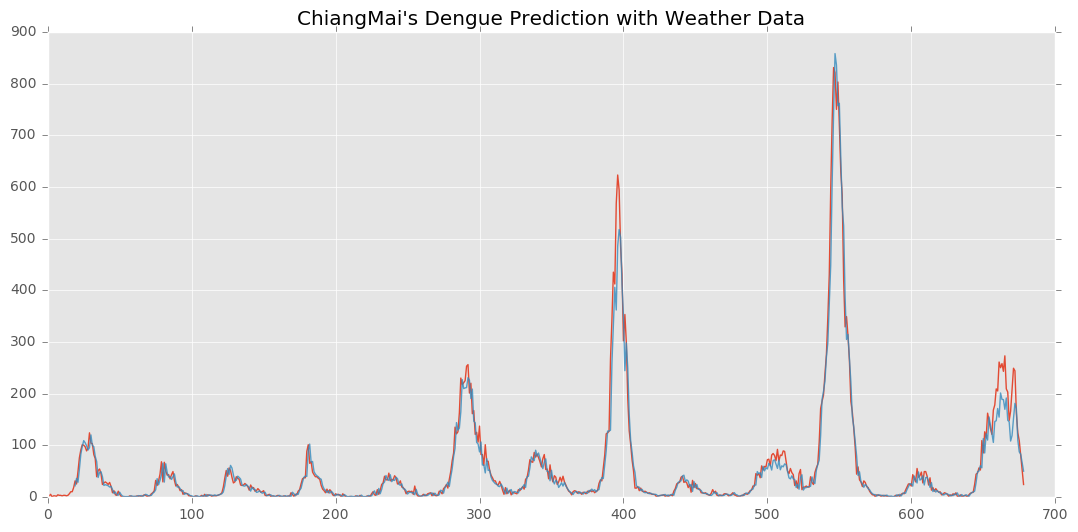

In [228]:
show_predictions(
                [19,9,15,1],
                cur_real,
                cur_train,
                cur_province,
                cur_ws)

In [359]:
# all_pred = predictions_to_validate
# plt.plot(all_pred[0][:-1]) # wk - 2
# plt.plot(np.array(cur_test.cases)[18:-2]) # wk - 1
# len(all_pred[0][:-1]) - len(np.array(cur_test.cases)[18:-2])

all_pred = predictions_to_validate
wks = [1,2,4,8,16]
percent_err = []
for i in range(5):
    wk = wks[i]
    if i <= 1:
        pred_test = all_pred[i][:-(i+1)]
        real_test = np.array(cur_test.cases)[18:-(wk+1)]
        print len(pred_test), len(real_test)
    else:    
        pred_test = all_pred[i][:-(wk-2)]
        real_test = np.array(cur_test.cases)[18+(wk-1):]
        print len(pred_test), len(real_test)
        
#     plt.plot(pred_test)
#     plt.plot(real_test)
#     plt.figure()
    cur_per_err = get_distances_percent(pred_test,real_test)
    percent_err.append(cur_per_err)

242 242
241 241
241 241
237 237
229 229


242 242
<
241 241
<
241 241
237 237
229 229


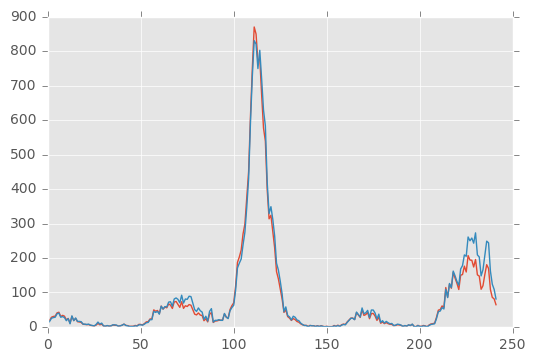

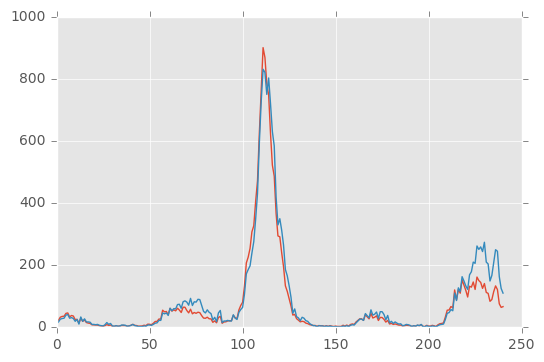

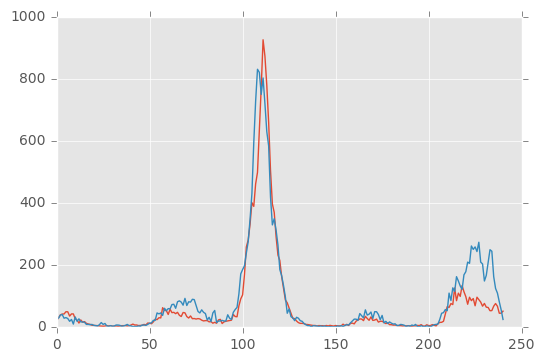

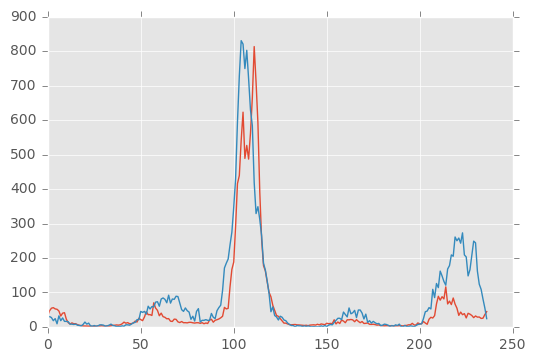

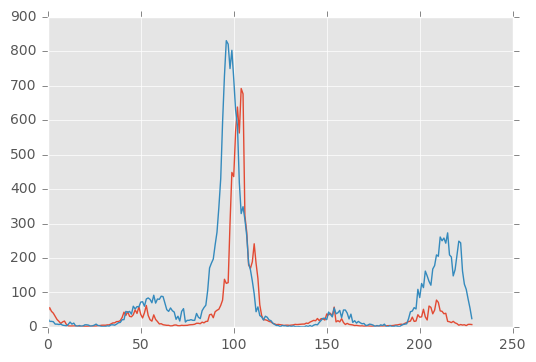

In [361]:
def get_distances_simple(all_predicitions, real):
    np_all_pred = np.array(all_predicitions)
    np_real = np.array(real)
    res = np_real - np_all_pred
    return res

all_pred = predictions_to_validate
wks = [1,2,4,8,16]
real_err = []
for i in range(5):
    wk = wks[i]
    if i <= 1:
        pred_test = all_pred[i][:-(i+1)]
        real_test = np.array(cur_test.cases)[18:-(wk+1)]
        print len(pred_test), len(real_test)
        print "<"
    else:    
        pred_test = all_pred[i][:-(wk-2)]
        real_test = np.array(cur_test.cases)[18+(wk-1):]
        print len(pred_test), len(real_test)
        
    plt.plot(pred_test)
    plt.plot(real_test)
    plt.figure()
    cur_per_err = get_distances_simple(pred_test,real_test)
    real_err.append(cur_per_err)

two_std_away_data has size of 222
mean: 33.108736; std: 74.337547
0.96943231441


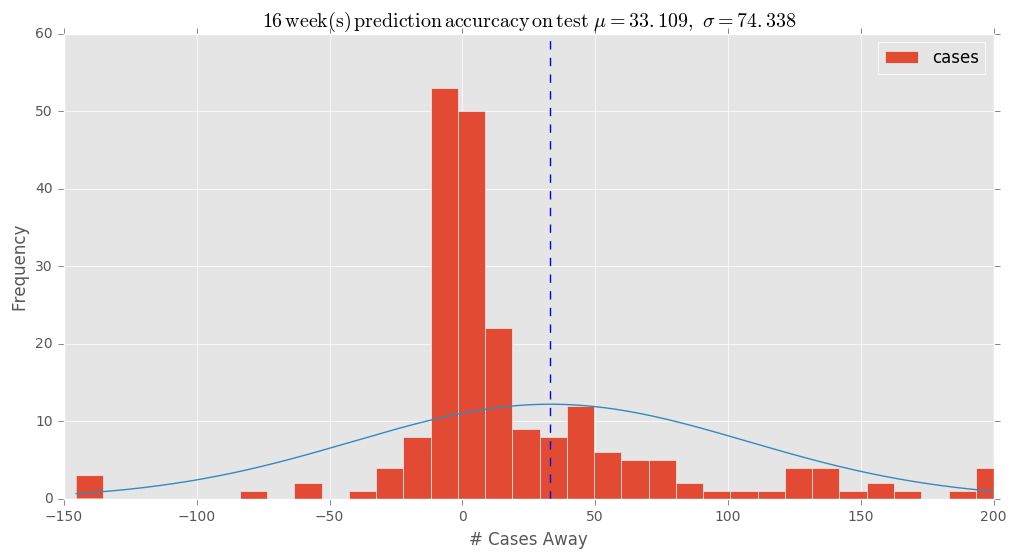

In [382]:
cur_distance_away_data = real_err[4]
two_std_away_data_plot = get_two_std_away(cur_distance_away_data)
two_std_away_data = np.array(two_std_away_data_plot)

(mu, sigma) = norm.fit(two_std_away_data)

n, bins, patches = plt.hist(two_std_away_data, 50, normed=1, alpha=0.75)
plt.close()
bin_width = bins[1] - bins[0]

week_to_predict = 16
title = r'$\mathrm{%d\,week(s)\,prediction\,accurcacy\,on\,test}\ \mu=%.3f,\ \sigma=%.3f$' %(week_to_predict,mu, sigma)
two_std_away_data_plot.plot(kind="hist",bins=50,title=title,figsize=(12,6)) # hist give bin size
plt.xlabel("# Cases Away")
range_ = np.arange(two_std_away_data.min(), two_std_away_data.max(), 0.001)
plt.plot(range_, norm.pdf(range_,two_std_away_data.mean(),two_std_away_data.std())*len(two_std_away_data)*bin_width)
plt.axvline(float(two_std_away_data.mean()),ls='--')
plt.xlim(-150,200)
# plt.savefig("model-03-16-weeks-prediction-accuracy-test-raw.pdf",dpi = 300, bbox_inches='tight')

print 'two_std_away_data has size of', len(two_std_away_data)
print 'mean: %f; std: %f'%(mu,sigma)
print len(two_std_away_data) / float(len(cur_distance_away_data))
# print len(two_std_away_data),len(outside_two_std),len(cur_distance_away_data)
# print outside_two_std.max(),outside_two_std.min()



In [14]:
test_err[0][1]

date
2011-05-29    -12.070751
2011-06-05     -6.343255
2011-06-12     -6.632713
2011-06-19     -6.190737
2011-06-26      6.361221
2011-07-03     13.566763
2011-07-10     17.982668
2011-07-17     14.158652
2011-07-24     12.779075
2011-07-31     26.003286
2011-08-07     -8.679253
2011-08-14      6.386979
2011-08-21    -14.180758
2011-08-28     12.435663
2011-09-04      1.809183
2011-09-11      7.305730
2011-09-18      6.003854
2011-09-25      4.273851
2011-10-02      4.317391
2011-10-09     -1.195993
2011-10-16      1.431130
2011-10-23      1.750709
2011-10-30      2.842632
2011-11-06     -2.912140
2011-11-13    -10.792747
2011-11-20     -5.587883
2011-11-27     -6.956851
2011-12-04      4.420246
2011-12-11      2.645990
2011-12-18      2.012326
                 ...    
2015-06-14    -54.591074
2015-06-21    -19.344389
2015-06-28    -64.527433
2015-07-05      5.203830
2015-07-12    -74.988835
2015-07-19    -26.933907
2015-07-26    -23.346131
2015-08-02     30.647297
2015-08-09    -33.56

In [216]:
def get_two_std_away(cur_predicted_weeks):
    cur_week_data = cur_predicted_weeks
    cur_week_mean = cur_week_data.mean()
    cur_week_std = cur_week_data.std()
    two_std = (cur_week_std*3)
    lower_bnd, upper_bnd = cur_week_mean - two_std, cur_week_mean + two_std
    cur_week_data_df = pd.DataFrame(cur_week_data)
    two_std_mask = (cur_week_data_df >= lower_bnd) & (cur_week_data_df <= upper_bnd)
    final_cur_week_data_df = pd.DataFrame(cur_week_data_df[two_std_mask])
    final_cur_week_data_df.columns = ['cases']
    final_cur_week_data_df = final_cur_week_data_df.dropna()
    return final_cur_week_data_df


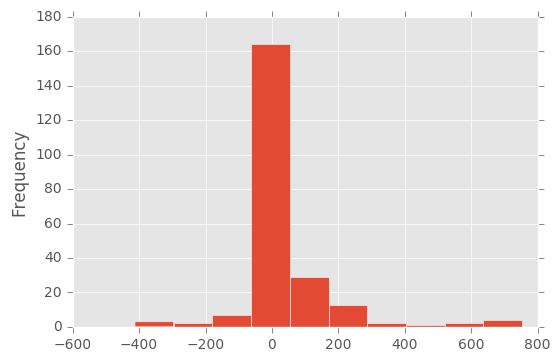

0.964757709251


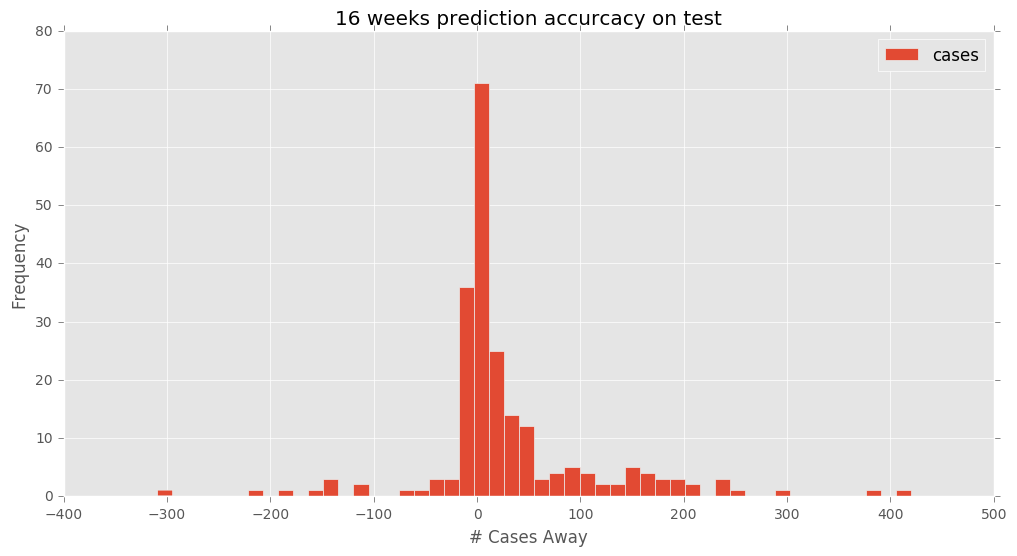

In [311]:
# weeks_predicted = [1,2,4,8,16]
# for idx, week in enumerate(weeks_predicted):
cur_distance_away_data = test_err[0][4]
two_std_away_data = get_two_std_away(cur_distance_away_data)

title = "16 weeks prediction accurcacy on test"
two_std_away_data.plot(kind="hist",bins=50,title=title,figsize=(12,6))
plt.xlabel("# Cases Away")
# plt.savefig("model-05-16-weeks-prediction-accuracy-test.pdf")
print len(two_std_away_data) / float(len(cur_distance_away_data))

### use chiang mai parameter for chiang rai

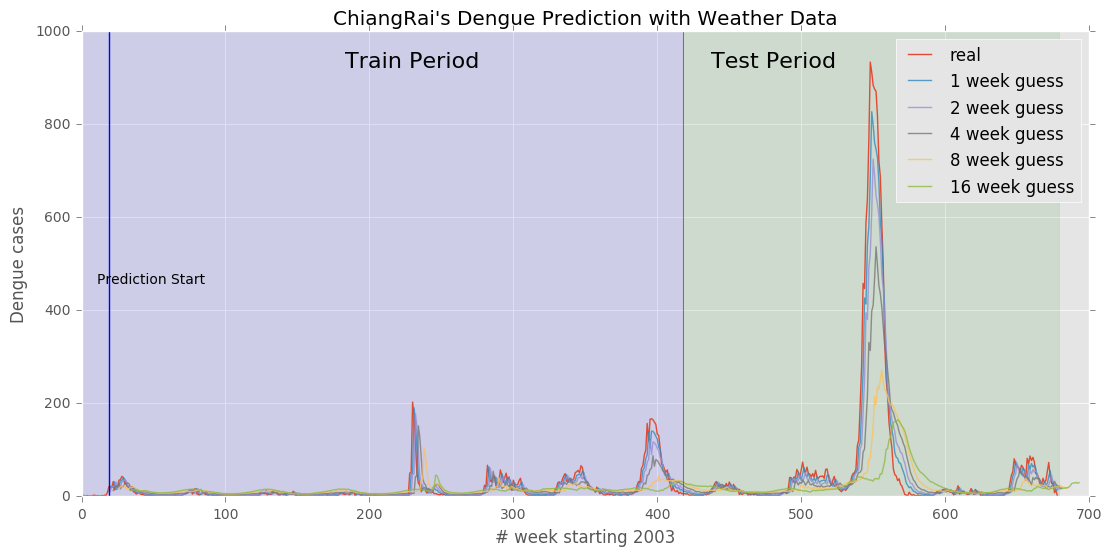

In [307]:
# raw_cm_ws = pd.read_csv("province-ws-for-ChiangMai.csv").T
# cm_ws = np.array(raw_cur_ws)[0]
# to_fix_province = "ChiangRai"
# cr_train = province_data[to_fix_province][0]
# cr_real = province_data[to_fix_province][1]
# show_predictions(
#                 [19,9,15,1],
#                 cr_real,
#                 cr_train,
#                 to_fix_province,
#                 cm_ws)


In [8]:
arr = []
for i_idx in range(len(test_err[0])):
    tmp = []
    for j_idx in range(len(test_err)):
        tmp.append(test_err[j_idx][i_idx])
    concat_tmp = np.append([],tmp)
    arr.append(concat_tmp)
    
predicted_weeks = pd.DataFrame(arr).T
predicted_weeks.columns = ['1_week','2_weeks','4_weeks','8_weeks','16_weeks']

0.967827626919
0.969598583235
0.961629279811
0.948642266824
0.917650531287


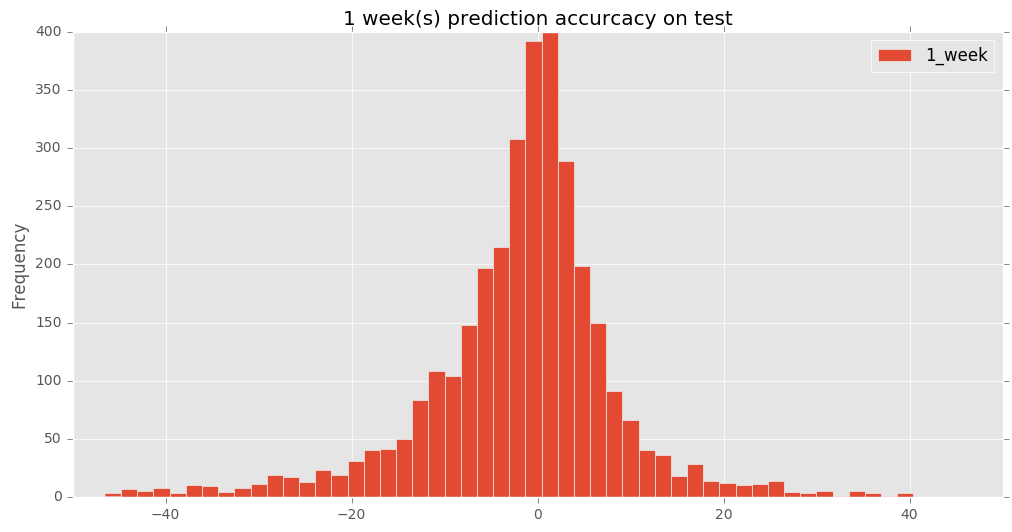

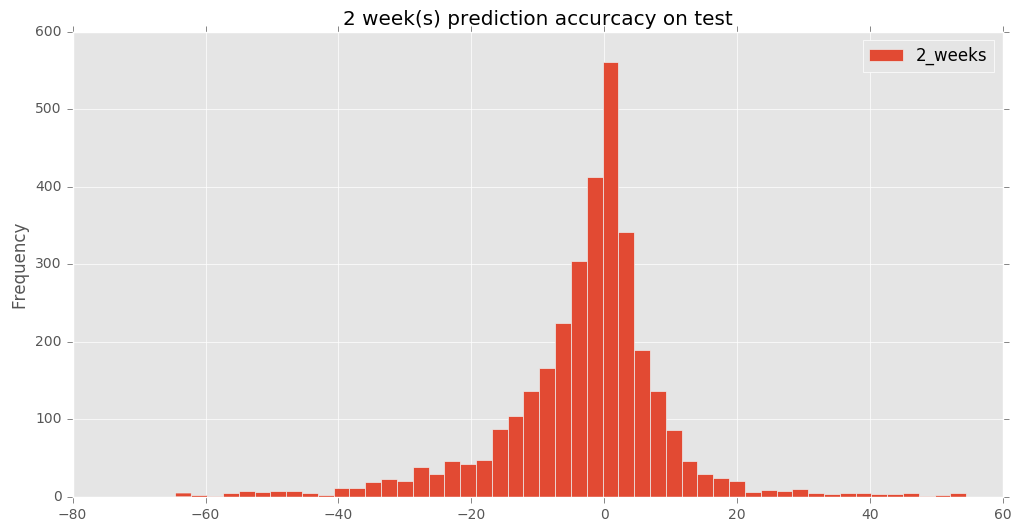

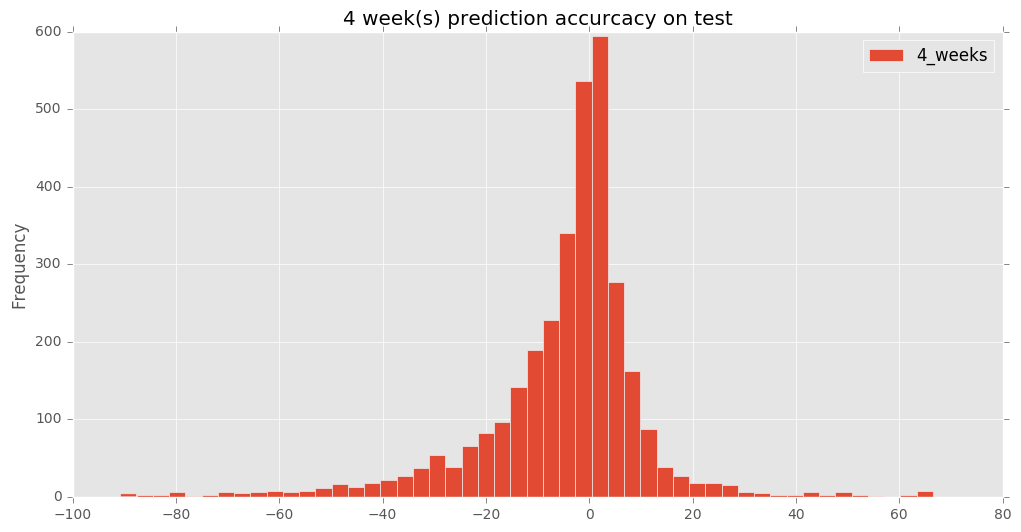

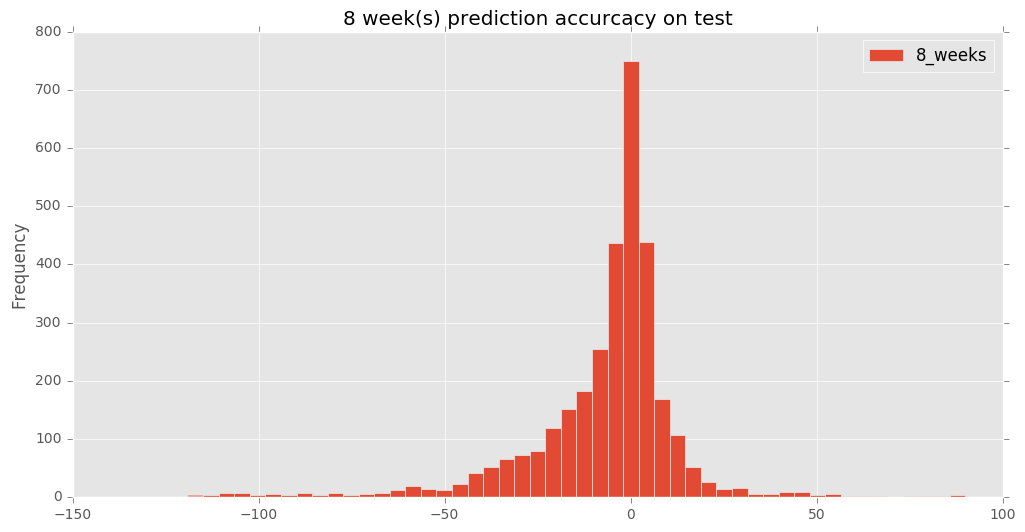

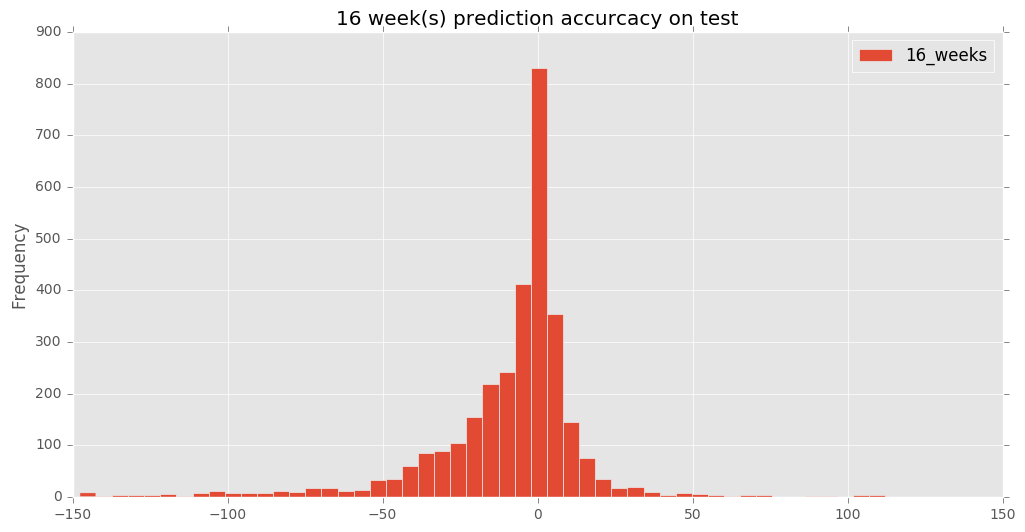

In [20]:
def get_two_std_away(cur_predicted_weeks):
    cur_week_data = cur_predicted_weeks
    cur_week_mean = cur_week_data.mean()
    cur_week_std = cur_week_data.std()
    two_std = (cur_week_std*2)
    lower_bnd, upper_bnd = cur_week_mean - two_std, cur_week_mean + two_std
    cur_week_data_df = pd.DataFrame(cur_week_data)
    two_std_mask = (cur_week_data_df >= lower_bnd) & (cur_week_data_df <= upper_bnd)
    final_cur_week_data_df = pd.DataFrame(cur_week_data_df[two_std_mask])
    final_cur_week_data_df = final_cur_week_data_df.dropna()
    return final_cur_week_data_df

weeks_predicted = [1,2,4,8,16]
for idx, week in enumerate(weeks_predicted):
    cur_distance_away_data = predicted_weeks.iloc[:,idx]
    two_std_away_data = get_two_std_away(cur_distance_away_data)
    
    title = "%d week(s) prediction accurcacy on test"%(week)    
    two_std_away_data.plot(kind="hist",bins=50,title=title,figsize=(12,6))
    print len(two_std_away_data) / float(len(cur_distance_away_data))
    

In [314]:
def get_deviations(LAG, all_predictions, real):
    
    def deviation(prediction, real):
        deviations_dict = {}
        for idx,real_case in enumerate(real):
            residual = real_case - prediction[idx]
#             sigma = (real_case+10)**0.5 

            score = residual / (real_case+1)
            score_arr = [score]

            if deviations_dict.has_key(real_case):
                deviations_dict[real_case].append(score)
            else:
                deviations_dict[real_case] = score_arr

        return deviations_dict
    
    def deviation_avg(in_dict):
        ret_dict = {}
        for key in in_dict:
            all_std = in_dict[key]
            avg_std = np.array(all_std).mean()
            ret_dict[key] = avg_std
        return ret_dict


    weeks = [1,2,4,8,16]
    ret = []
    for idx,prediction in enumerate(all_predictions):
        cur_pred = np.array(prediction)
        # compare with real
        # doesnt take into the accout of the predicted week(s)
        cur_pred_range = cur_pred[:-weeks[idx]]
        real_range = real.cases[LAG+weeks[idx]:]
        raw_deviation_real_cases = deviation(cur_pred_range,real_range)
        avg_deviation_real_cases = deviation_avg(raw_deviation_real_cases)
        ret.append(avg_deviation_real_cases)
        

    return ret

In [315]:
# number of cases
test_std = []
for ws_set_file in chosen_ws:
    raw_cur_ws = pd.read_csv(ws_set_file).T
    cur_ws = np.array(raw_cur_ws)[0]
    cur_province = ws_set_file[16:-4]
    cur_train = province_data[cur_province][0]
    cur_real = province_data[cur_province][1]
    cur_test = province_data[cur_province][2]
    
    print cur_province
    
#     """see how unique real cases there are"""
#     a = np.array(cur_test.cases.unique())
#     print len(np.sort(a))
    
#     print cur_test.tail()
    
    predictions_to_validate = prediction_humidity.get_predictions(
        19,9,15,1,
        cur_test,
        cur_ws)
    
    cur_test_std = get_deviations(
        19,
        predictions_to_validate,
        cur_test)
    
    test_std.append(cur_test_std)

ChiangMai
ChiangRai
ChonBuri
MahaSarakham
NakhonPathom
NongKhai
Pattani
PhraNakhonSiAyutthaya
PrachuapKhiriKhan
Ratchaburi
SakonNakhon
SamutPrakan
Songkhla
SuratThani


In [316]:
all_weeks_arr = []
for i_idx in range(len(test_std[0])):
    cur_week_arr = []
    for j_idx in range(len(test_std)):
        temp_df = pd.DataFrame(test_std[j_idx][i_idx].values()).T
        temp_df.columns = test_std[j_idx][i_idx].keys()
        cur_week_arr.append(temp_df)
    cur_week_df = pd.concat(cur_week_arr)
    all_weeks_arr.append(cur_week_df)



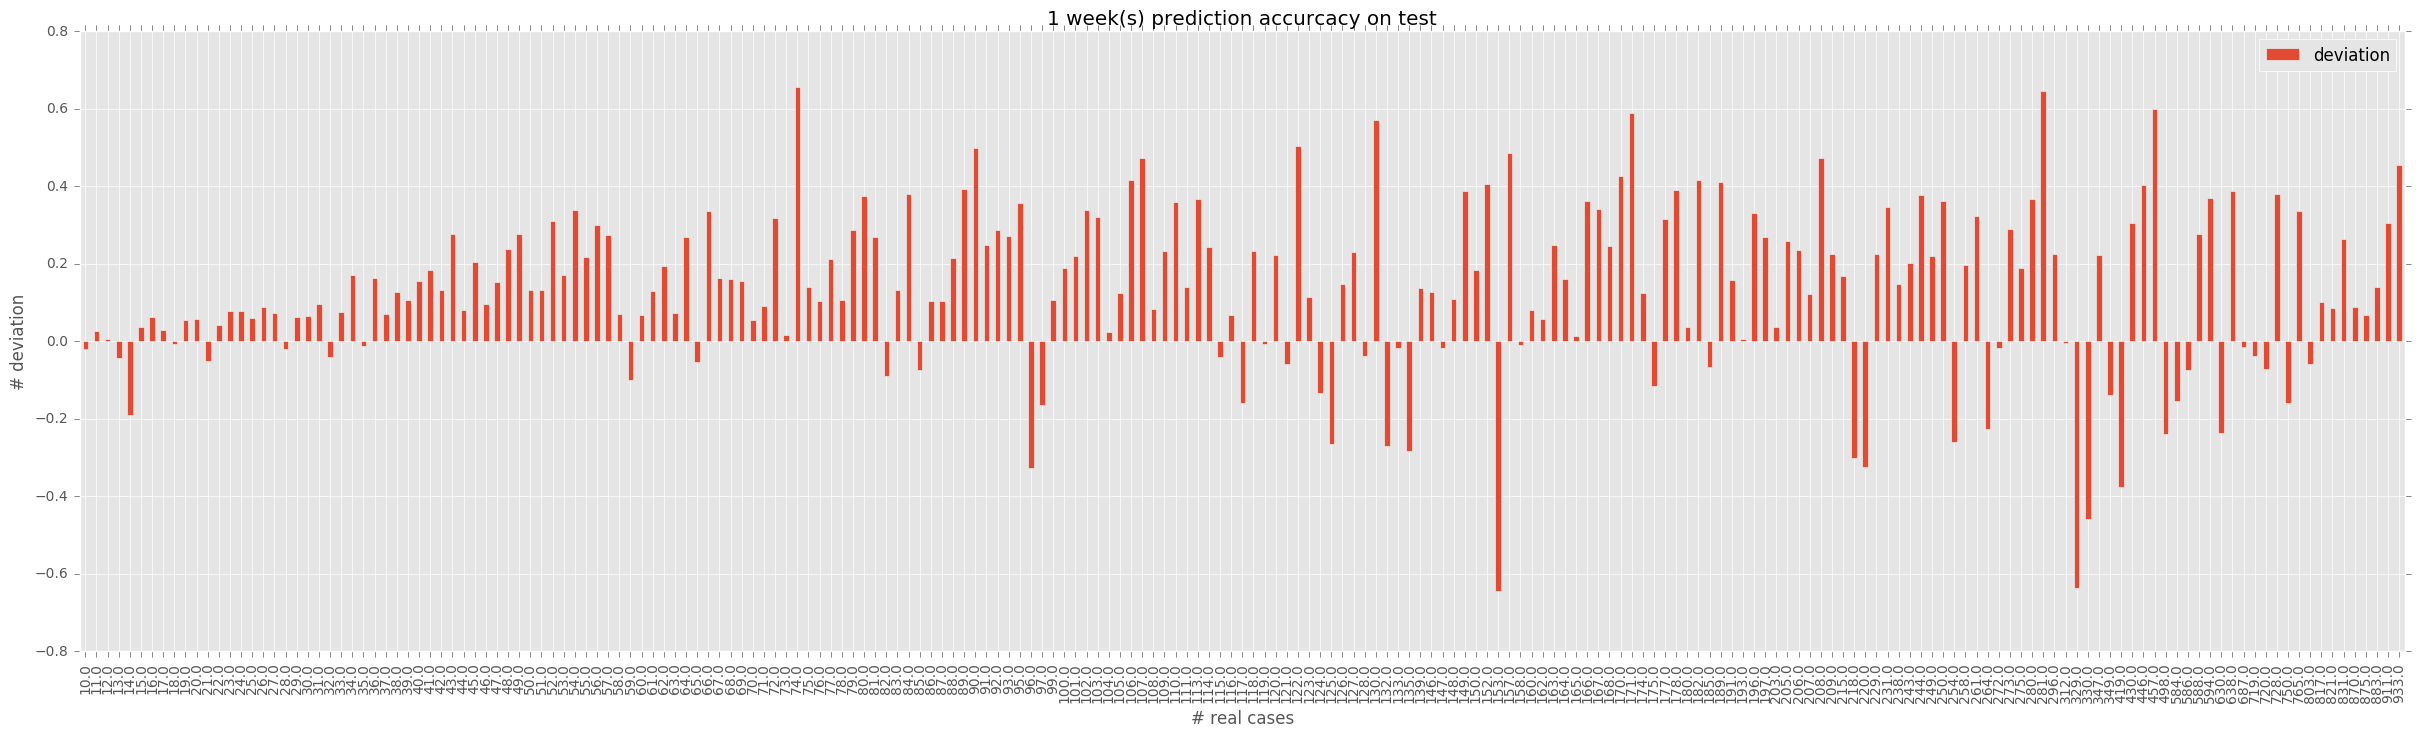

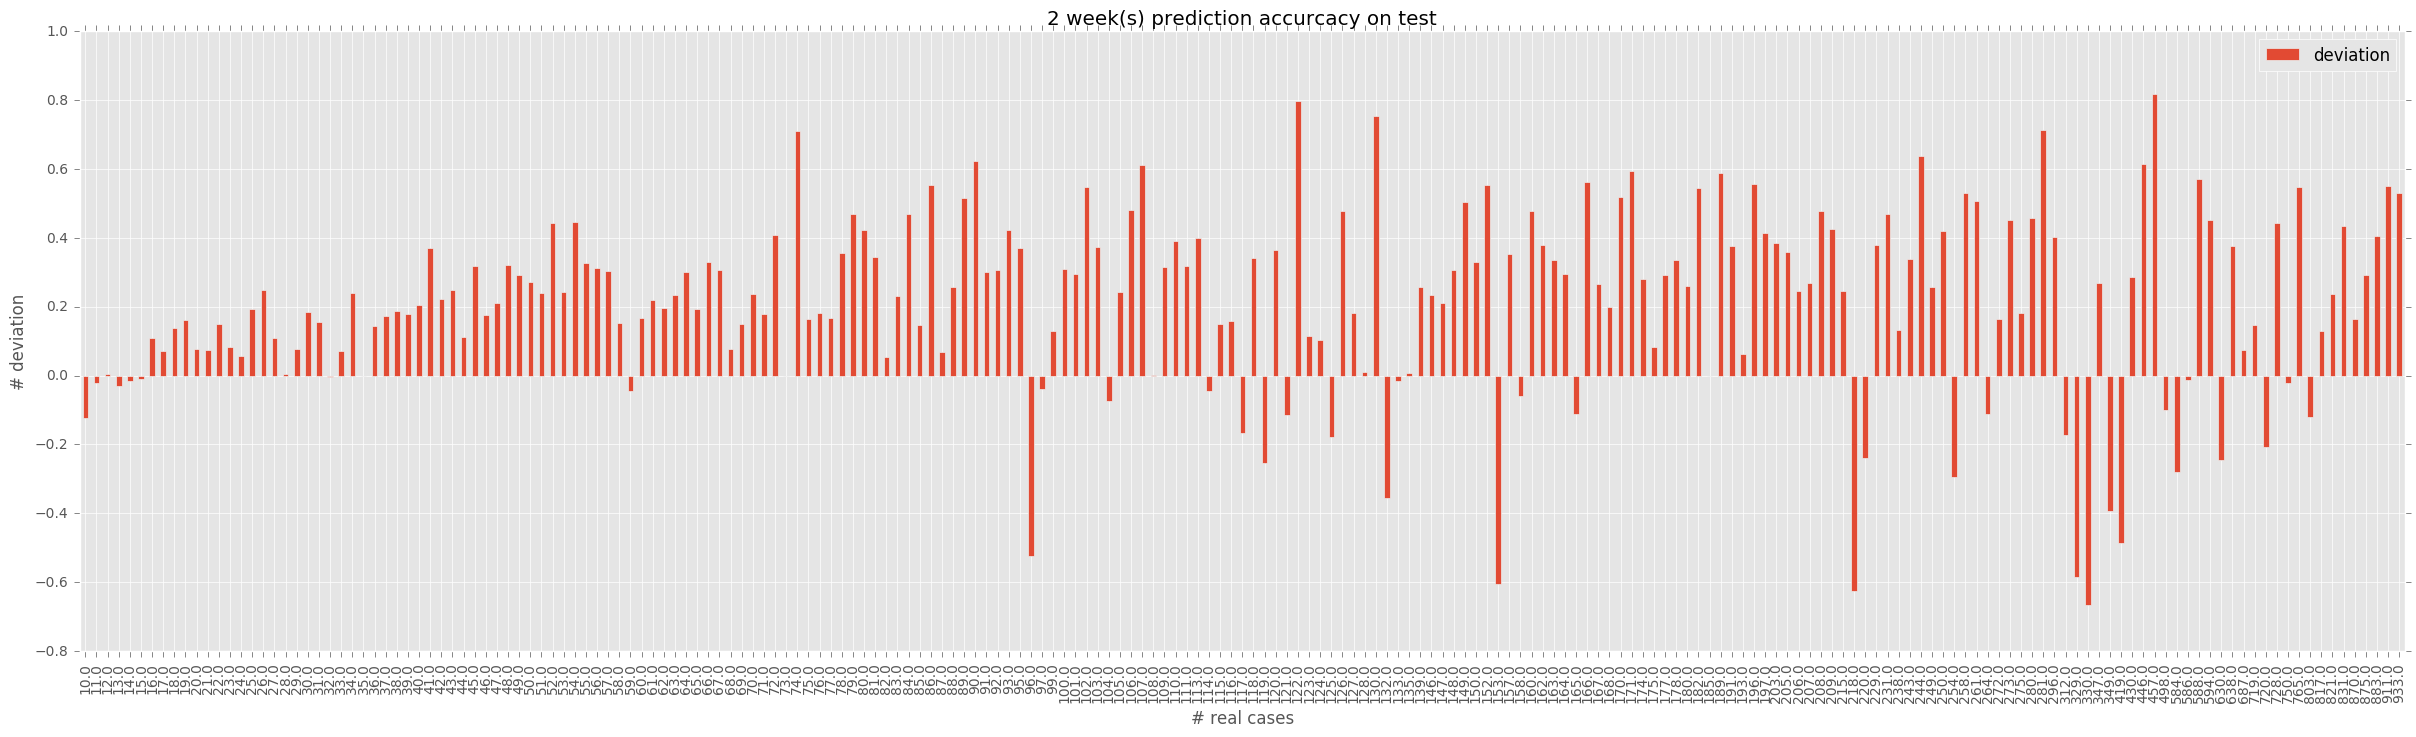

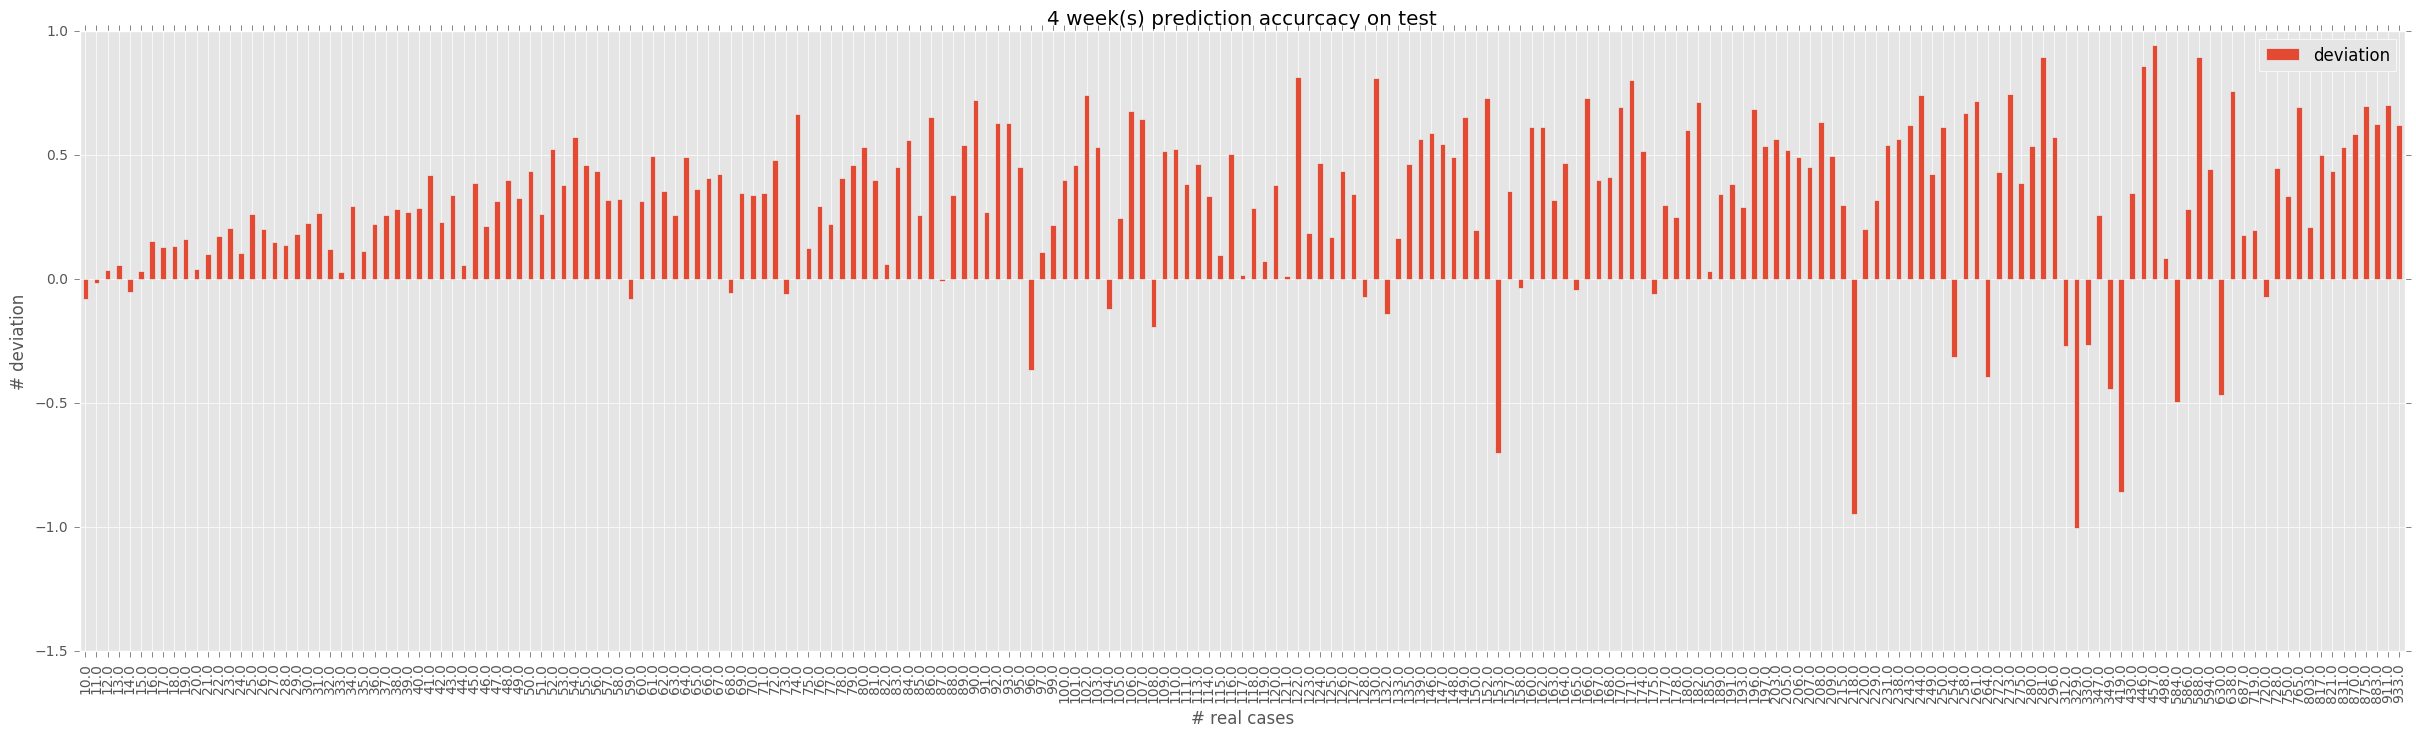

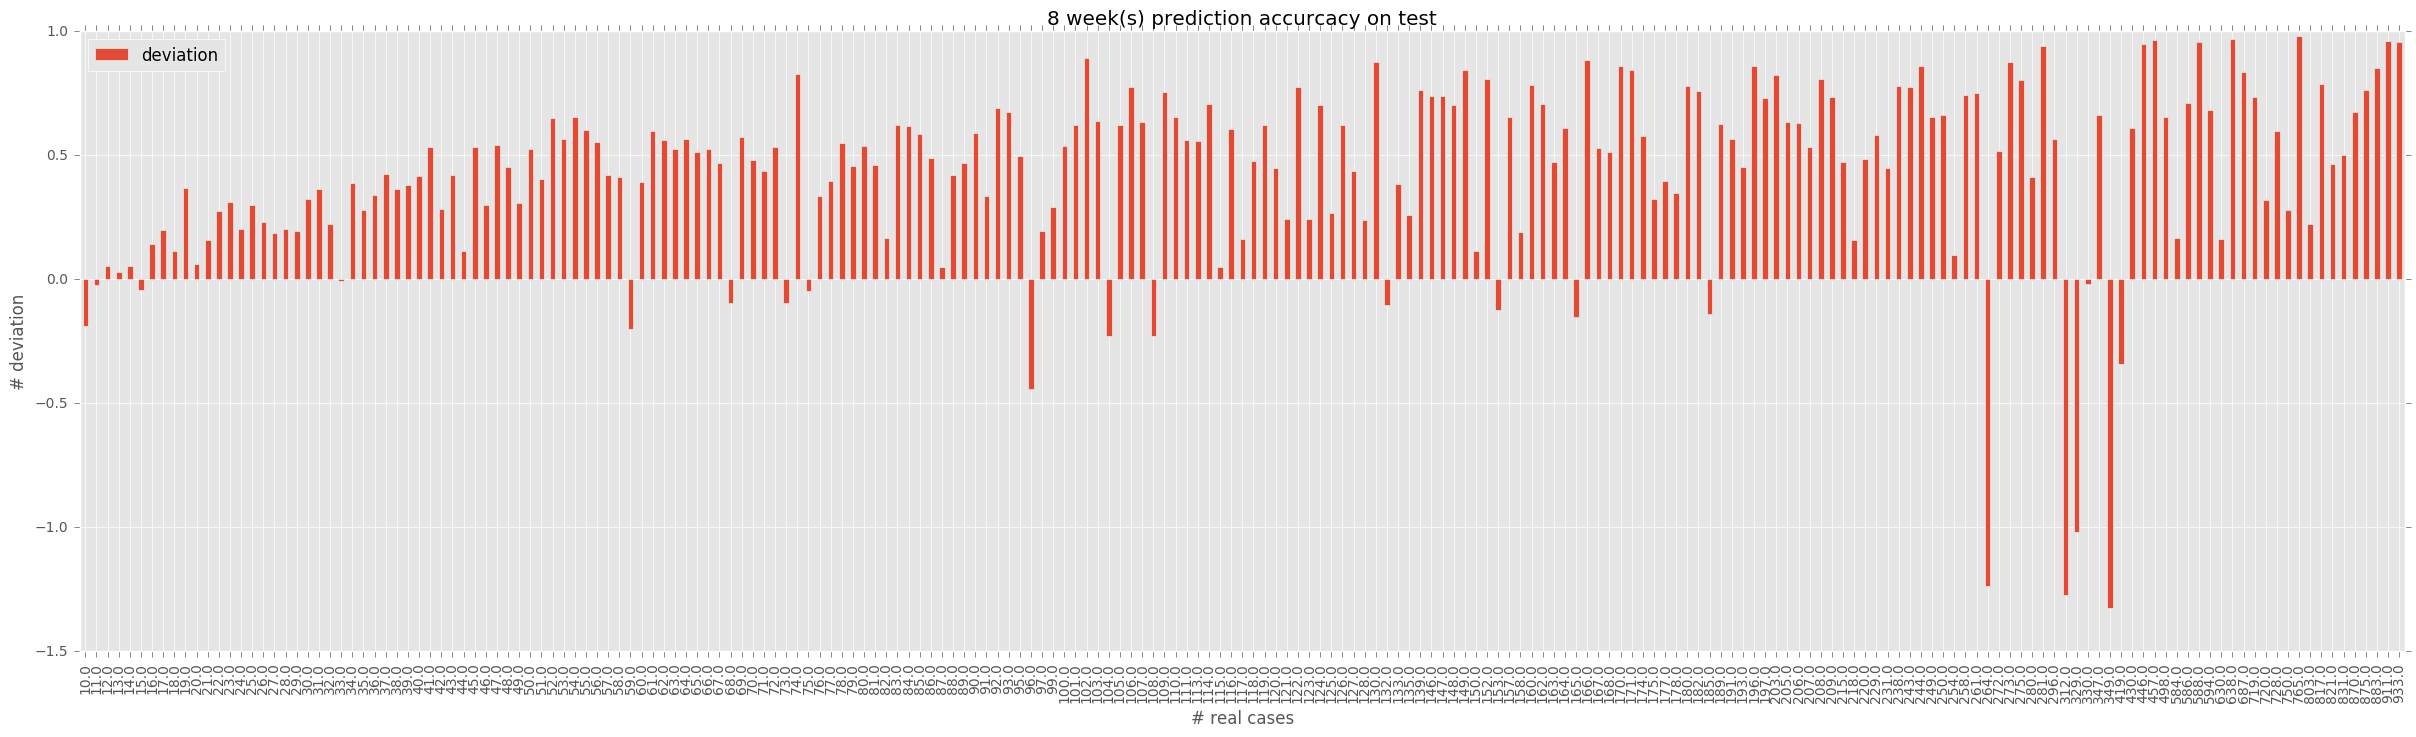

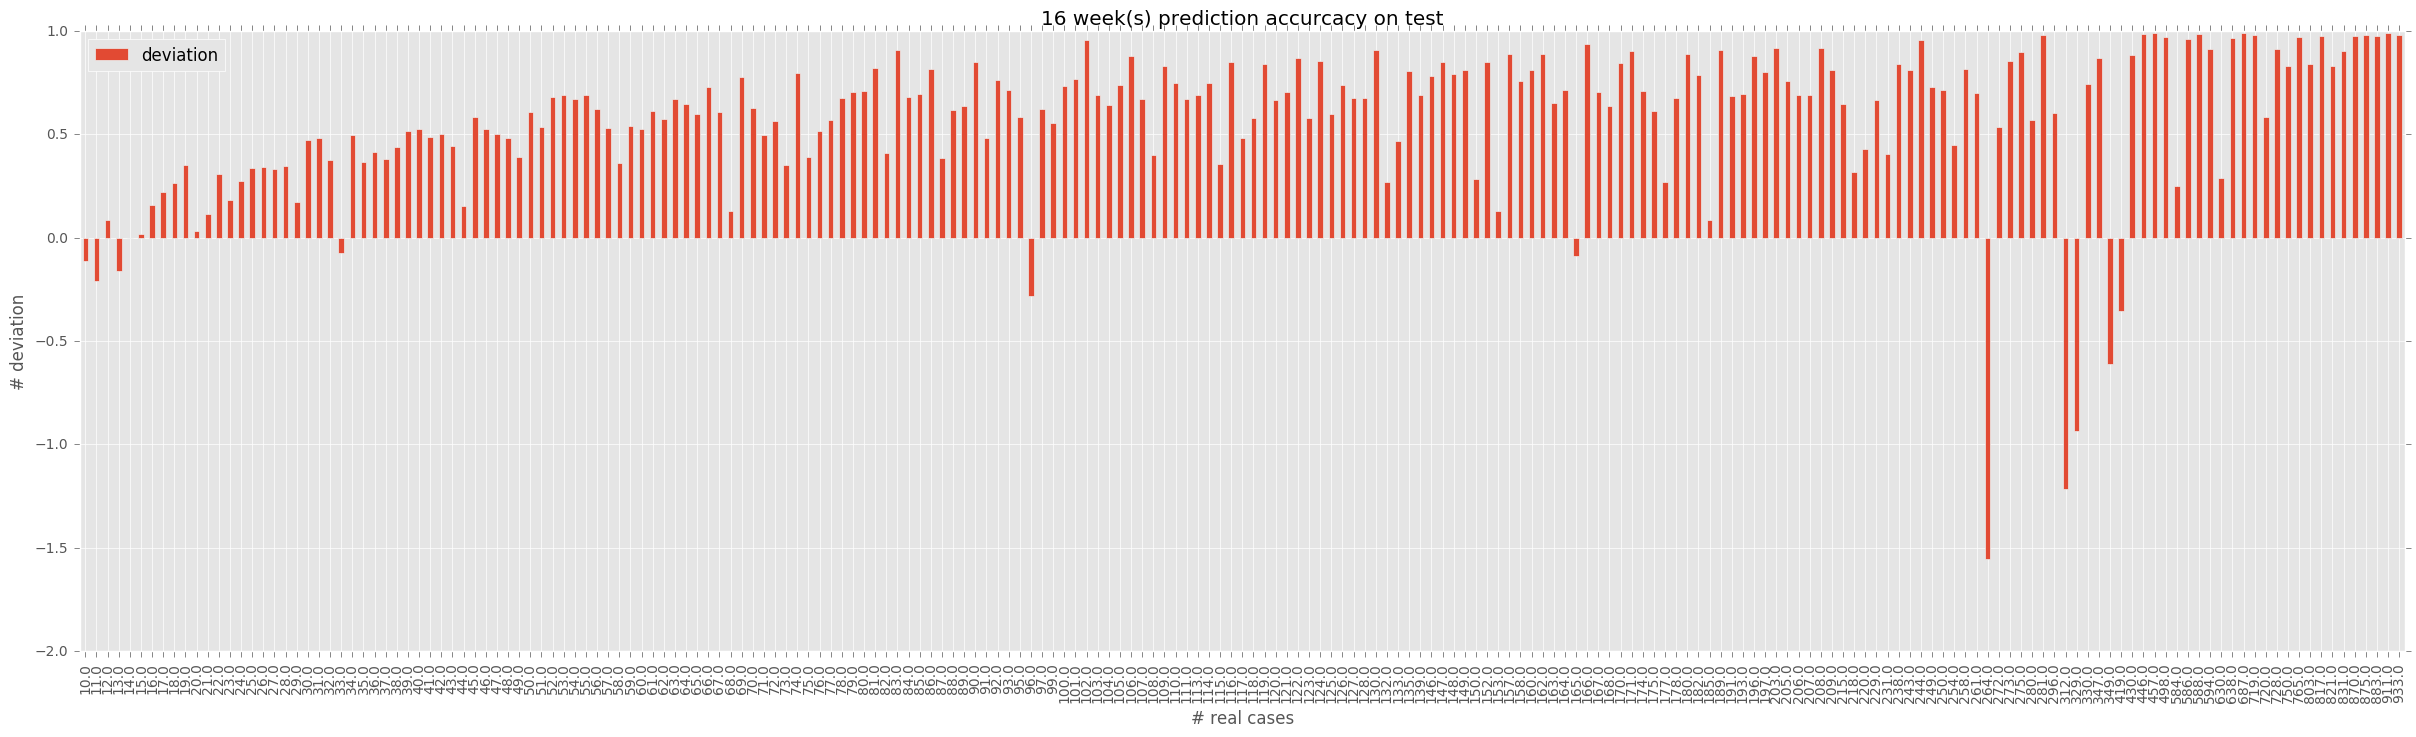

In [317]:
def combine_df(week_prediction):
    mean_week_prediction = week_prediction.mean()
    mean_week_prediction_df = pd.DataFrame(mean_week_prediction)
    mean_week_prediction_df['real_case'] = mean_week_prediction_df.index
    mean_week_prediction_df = mean_week_prediction_df.reset_index(drop=True)
    mean_week_prediction_df.columns = ['deviation','real_case']
    return mean_week_prediction_df

def plot_bar(predicted_weeks,week):
    title = "%d week(s) prediction accurcacy on test"%(week)
    predicted_weeks[10:].plot.bar(y='deviation',x='real_case',title=title,figsize=(30,8))
    plt.ylabel("# deviation")
    plt.xlabel("# real cases")

weeks_predicted = [1,2,4,8,16]
for idx, week in enumerate(weeks_predicted):
    predicted_weeks = combine_df(all_weeks_arr[idx])
    plot_bar(predicted_weeks,week)